We will implement a Gibbs sampling algortihm to sample the factors from the conditional posterior distrubtions in the MVGMF algorithm to factorise our matrix. We will call this algortihm Bayesian Gaussian Matrix Factorisation (BGMF) for now.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.special import logsumexp

In [2]:
def calculate_nmse(Y, Y_pred):
    numerator = np.linalg.norm(Y - Y_pred, 'fro') ** 2
    denominator = np.linalg.norm(Y, 'fro') ** 2
    nmse = numerator / denominator
    return nmse

In [3]:
def matrix_normal_sample(M, U, V):
    #return np.random.multivariate_normal(M.ravel(), np.kron(V, U)).reshape(M.shape)
    n, p = M.shape

    # Generate samples from standard normal distribution
    X = np.random.normal(0, 1, size=(n, p))

    # Compute Cholesky decomposition of covariance matrices
    chol_U = np.linalg.cholesky(U)
    chol_V = np.linalg.cholesky(V)

    # Sample from matrix normal distribution
    Y = M + chol_U @ X @ chol_V.T

    return Y

In [4]:
def BGMF(Y, k, r, T, sigma_2, burnin = 100, return_running_average = False, return_samples=False):
    """
    Perform Bayesian Gaussian Matrix Factorization (BGMF) using Gibbs sampling.

    Parameters:
    - Y (numpy.ndarray): The input matrix of shape (m, n) to be factorized.
    - k (float): A constant for the variate matrix initialization.
    - r (int): The dimensionality of the factorization.
    - T (int): The number of Gibbs sampling iterations.
    - burnin(int): Specifies burnin iterations.
    - return_running_average (boolean): Returns running array average of C and X.
    - return_samples (boolean): Returns array of samples of C and X at each iteration.

    Returns:
    - C (numpy.ndarray): The factor matrix C of shape (m, r).
    - X (numpy.ndarray): The factor matrix X of shape (r, n).
    """
    m, n = Y.shape
    #Initialise the matrices
    V_0 = k * np.eye(r)
    W_0 = k * np.eye(r)
    C_0 = np.random.normal(0, 1, size=(m, r))
    X_0 = np.random.normal(0, 1, size=(r, n))
    C_prev = C_0
    X_prev = X_0

    #Stores running average of C and X after burnin
    C_samples = []
    X_samples = []
    V_samples = []
    W_samples = []
    C_running_average = []
    X_running_average = []
    C_average = np.zeros((m, r))
    X_average = np.zeros((r, n))

    for t in range(T):
        
        
        V = V_0 - V_0 @ X_prev @ np.linalg.inv(sigma_2*np.eye(n) + X_prev.T @ V_0 @ X_prev).T @ X_prev.T @ V_0.T
        
        C_mean = C_prev + (Y - C_prev @ X_prev) @ \
                    np.linalg.inv(sigma_2*np.eye(n) + X_prev.T @ V_0 @ X_prev).T @ X_prev.T @ V_0.T
        
        C = matrix_normal_sample(C_mean, np.eye(m), V)
        
        
        W = W_0 - W_0 @ C.T @ np.linalg.inv(sigma_2*np.eye(m) + C @ W_0 @ C.T) @ C @ W_0
        
        X_mean = X_prev + W_0 @ C.T @ np.linalg.inv(sigma_2*np.eye(m) + C @ W_0 @ C.T) @ (Y - C @ X_prev)
        
        X = matrix_normal_sample(X_mean, W, np.eye(n))
        
        C_prev = C
        X_prev = X
        

        if t >= burnin:
            #Calculates the running average of C and X (to plot)
            if t == burnin:
                C_average = C
                X_average = X
                C_running_average.append(C_average)
                X_running_average.append(X_average)
                
            else:
                N = t - burnin + 1
                C_average = (C / N) + (C_average * (N - 1) / N)
                X_average = (X / N) + (X_average * (N - 1) / N)
                C_running_average.append(C_average)
                X_running_average.append(X_average)
                
            #Stores the samples at each stage after burnin
            C_samples.append(C)
            X_samples.append(X)
            V_samples.append(V)
            W_samples.append(W)
                
            

    if return_running_average:
        return C_average, X_average, C_running_average, X_running_average
    
    elif return_samples:
        return C_average, X_average, C_samples, X_samples, V_samples, W_samples, C_0, X_0, V_0, W_0
            
    return C_average, X_average

In [5]:
def calculate_running_average(Y):
    result = []
    result.append(Y[0])
    Y_average = Y[0]
    for i in range(1, len(Y)):
        Y_average = (Y[i] / (i+1)) + (Y_average * (i) / (i+1))
        result.append(Y_average)
    return result

In [6]:
m = 5
r = 3
n = 25
burnin = 100
T = 500
sigma_2 = 1

C = np.random.normal(0, 1, size=(m, r))
X = np.random.normal(0, 1, size=(r, n))

Y = C @ X
#C_pred, X_pred, C_average, X_average = BGMF(Y, 1, r, T, burnin = burnin, return_running_average = True)
C_pred, X_pred, C_samples, X_samples, V_samples, W_samples, C_0, X_0, V_0, W_0 \
                    = BGMF(Y, 1, r, T, sigma_2, burnin = burnin, return_samples = True)
    
C_average = calculate_running_average(C_samples)
X_average = calculate_running_average(X_samples)

Y_pred = C_pred @ X_pred
#RUNNING PREDICITION CALCULATION
Y_pred_running = [C @ X for C, X in zip(C_average, X_average)]
nmse_running = [calculate_nmse(Y, Y_pred) for Y_pred in Y_pred_running]

calculate_nmse(Y, Y_pred)

0.0595902263744006

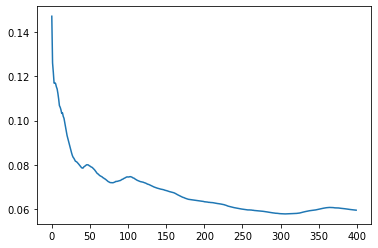

In [7]:
plt.plot(range(T-burnin), nmse_running)

### Marginal Likelihood from BGMF for different values of r

In BGMF, we implement Gibbs Sampling for complete conditionals which we derived:

$$
f(C|Y, X) = \mathcal{N}(c;c_p, V \otimes I_m) = \mathcal{MN}(C;C_p, I_m, V), 
$$
$$
f(X|Y, C) = \mathcal{N}(c;x_p, I_n \otimes W) = \mathcal{MN}(X;X_p, W, I_n), 
$$

Using https://www.tandfonline.com/doi/pdf/10.1080/01621459.1995.10476635, the estimate of the marginal likelihood is:

$$
\log p(Y) = \log P(Y|C^*,X^*) + \log p(X^*) + \log p(C^*) - \log p(C^*|X^*,Y) - \log p(X^*|Y)
$$


where $C^*$ and $X^*$ are our selected points taken to be the average points of sampler output from our outputs of BGMF $\{C^{(t)}, X^{(t)}\}_{t=1}^T$.

The last term can be estimated by:

$$
p(\widehat{X^*|Y}) = \frac{1}{T}\sum_{i=1}^Tp(X^*|C^{(i)}, Y)
$$

Question on vec(A), do vec stack columns or rows (depends direction of how we define each data vector in Y?), so in our case stack rows?

In [8]:
def evaluate_log_density(X, M, U, V):
    #evaluates log pdf for X that follows MN(M, U, V)
    n, p = X.shape
    log_density = -0.5 * np.trace(np.linalg.solve(V, (X-M).T) @ np.linalg.solve(U, (X - M)))
    log_density -= 0.5 * (n * p * np.log(2*np.pi) + n * np.log(np.linalg.det(V)) + p * np.log(np.linalg.det(U)))
    return log_density

In [13]:
def log_marginal_likelihood(C_samples, X_samples, V_samples, W_samples, Y, sigma_2, C_0, X_0, V_0, W_0):
    
    m, n = Y.shape
    C_star = calculate_running_average(C_samples)[-1]
    X_star = calculate_running_average(X_samples)[-1]
    T = len(X_samples)
    term1 = evaluate_log_density(Y, C_star@X_star, sigma_2*np.eye(m), sigma_2*np.eye(n))
    term2 = evaluate_log_density(X_star, X_0, W_0, np.eye(n))
    term3 = evaluate_log_density(C_star, C_0, np.eye(m), V_0)
    
    C_p = C_0 + (Y - C_0 @ X_star) @ np.linalg.inv((sigma_2*np.eye(n) + X_star.T @ V_0 @ X_star)).T @ X_star.T @ V_0.T
    V_p = V_0 - V_0 @ X_star @ np.linalg.inv(sigma_2*np.eye(n) + X_star.T @ V_0 @ X_star).T @ X_star.T @ V_0.T
    term4 = evaluate_log_density(C_star, C_p, np.eye(m), V_p)
    
    X_p_array = [X_0 + W_0 @ C_i.T @ np.linalg.inv(sigma_2*np.eye(m) + C_i @ W_0 @ C_i.T) @ (Y - C_i @ X_0) for C_i in C_samples]
    #W_p = W_0 - W_0 @ C_star.T @ np.linalg.inv(sigma_2*np.eye(m) + C_star @ W_0 @ C_star.T) @ C_star @ W_0
    W_p_array = [W_0 - W_0 @ C_i.T @ np.linalg.inv(sigma_2*np.eye(m) + C_i @ W_0 @ C_i.T) @ C_i @ W_0 for C_i in C_samples]
    
    #term5_log_array = [evaluate_log_density(X_star, X_p, W_p, np.eye(n)) for X_p in X_p_array]
    term5_log_array = [evaluate_log_density(X_star, X_p, W_p, np.eye(n)) for X_p, W_p in zip(X_p_array, W_p_array)]
    
    term5 = logsumexp(term5_log_array) - np.log(T)
    print(term1, term2, term3, term4, term5)
    return term1 + term2 + term3 - term4 - term5
    

In [14]:
res = log_marginal_likelihood(C_samples, X_samples, V_samples, W_samples, Y, sigma_2, C_0, X_0, V_0, W_0)


-711.580376949659 -224785.52963371453 -104.9343604150629 341.99778088698173 -223262.07313408452


### Plot for different values of r

-2200.10383409262 -452430.87665167614 -25.075979767110134 75.60122581547638 -451056.1171262579
-1371.0768559096632 -765022.401186329 -47.51174270132037 160.07854002391326 -762829.8964346412
-1019.1632237325364 -1002898.9387925912 -64.68102772005838 240.65780877561042 -1000377.6048114522
-800.796505692068 -1046991.4291483152 -81.27513108470671 293.96460805134774 -1044252.7656646032
-714.32391717337 -1528528.236332183 -114.96781719635895 410.10560470992607 -1525751.9666847598
-734.4577650028396 -1800595.2060375367 -128.80962092938054 470.41052620980764 -1797802.733824935
-820.69242276713 -2030102.7238347393 -144.83698047871522 479.7260698855452 -2027354.3259776304
-820.9258313494804 -1785464.6225893428 -168.03960117617936 538.1078387876953 -1782764.6998272385
-786.942383519674 -2002547.983941348 -174.0062922756561 668.7574800209293 -1999854.632037861


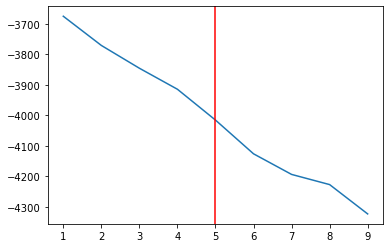

In [18]:
m = 15
n = 50
true_r = 5
burnin = 10000
T = 50000
sigma_2 = 1
r_vals = [i for i in range(1, 10)]
log_likelihoods = []

#Generate data
C = np.random.normal(0, 1, size=(m, true_r))
X = np.random.normal(0, 1, size=(true_r, n))
Y = C @ X

for r in r_vals:
    C_pred, X_pred, C_samples, X_samples, V_samples, W_samples, C_0, X_0, V_0, W_0 \
                    = BGMF(Y, 1, r, T, sigma_2, burnin = burnin, return_samples = True)
    log_likelihoods.append(log_marginal_likelihood(C_samples, X_samples, V_samples, W_samples, Y, sigma_2, C_0, X_0, V_0, W_0))
    
plt.plot(r_vals, log_likelihoods)
plt.axvline(true_r, color='r')